# Лабораторная работа 3
> Выполнена студентом: **Гришин Е.В. 22ВВИм2**

Цель лабораторной работы:
1. Метрики качества.
2. Фильтрация изображений
3. Линейная фильтрация изображений в пространственной области.
4. Линейная фильтрация изображений в частотной области

## Импорт библиотек

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import cv2 as cv
import numpy as np

image_path = 'images/lab3_bad.jpg'

## Загрузка изображения

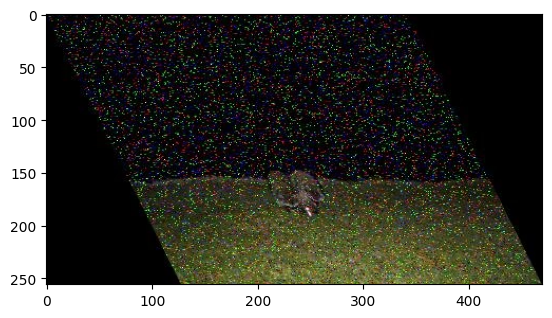

In [2]:
# Загрузка изображения
bgr_image = cv.imread(image_path)
rgb_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2RGB)

# plt.imshow(gray_image, cmap='gray')
plt.imshow(rgb_image)

## Гиперпараметры

In [3]:
filter_ksize_first = 5
filter_ksize_second = 9
median_ksize = 5
spectre_coeff = 1.0


## Индивидуальное задание. Восстановление изображения.

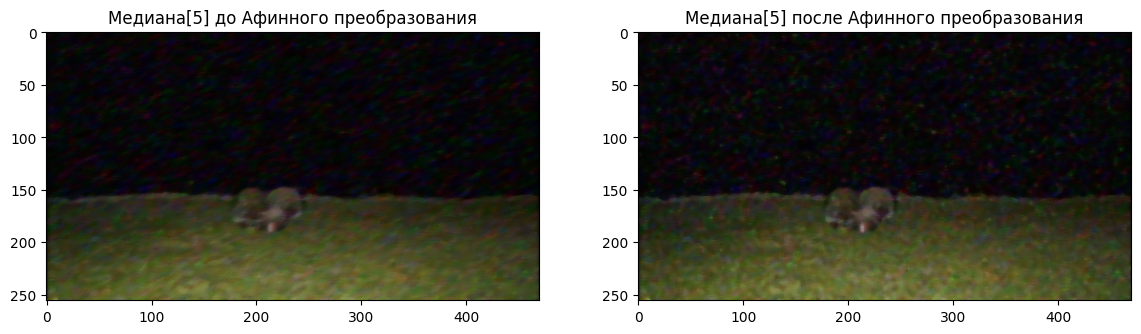

In [4]:
image_shape = rgb_image.shape
x_warp = 127

warp_points = [[0, 0], [image_shape[1], 0], [0, image_shape[0]]]
warped_points = [[0, 0], [image_shape[1], 0], [0, image_shape[0]]]
warped_points[1][0] -= x_warp
warped_points[2][0] += x_warp

src = np.array(warped_points, dtype='float32')
dst = np.array(warp_points, dtype='float32')

transformation = cv.getAffineTransform(src, dst)

before = cv.medianBlur(rgb_image, median_ksize)
before = cv.warpAffine(before, transformation, image_shape[1::-1])

after = cv.warpAffine(rgb_image, transformation, image_shape[1::-1])
after = cv.medianBlur(after, median_ksize)

f, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].imshow(before)
axes[0].set_title('Медиана[{}] до Афинного преобразования'.format(median_ksize))
axes[1].imshow(after)
axes[1].set_title('Медиана[{}] после Афинного преобразования'.format(median_ksize))

restored_image = after

## Сжать изображение

In [5]:
from numpy.linalg import svd

def bin_search(desc, threshold=100):
    l, r = 0, len(desc)
    while r > l:
        m = (l + r) // 2
        if desc[m] >= threshold:
            l = m + 1
        else:
            r = m
    return l - len(desc)
        


def decompose(image, output=False): # image of shape (N, M, channels)
    layered_image = np.swapaxes(image, 0, 2)
    U, S, Vh = svd(layered_image, full_matrices=False)
    
    for layer in S:
        # adaptively search for low values
        pos = bin_search(layer)
        if output:
            print('Removed {} params from S'.format(-pos))
        if pos < 0:
            layer[pos:] = 0
    
    simple_image = np.matmul(U * S[..., None, :], Vh)
    return np.swapaxes(simple_image, 0, 2).astype(np.uint8)

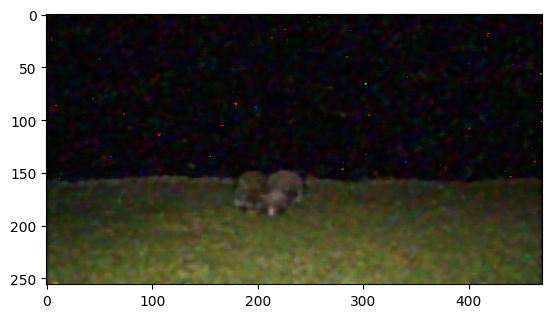

In [6]:
plt.imshow(decompose(restored_image))

## Сглаживание

In [7]:
def blur_gauss(image, sz):
    return cv.GaussianBlur(image, (sz, sz), 1.5)

def blur_linear(image, sz):
    return cv.filter2D(image, -1, np.ones((sz, sz), dtype=np.float64) / (sz * sz))

def sharpen(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]], dtype=np.int64)
    return cv.filter2D(image, -1, kernel)

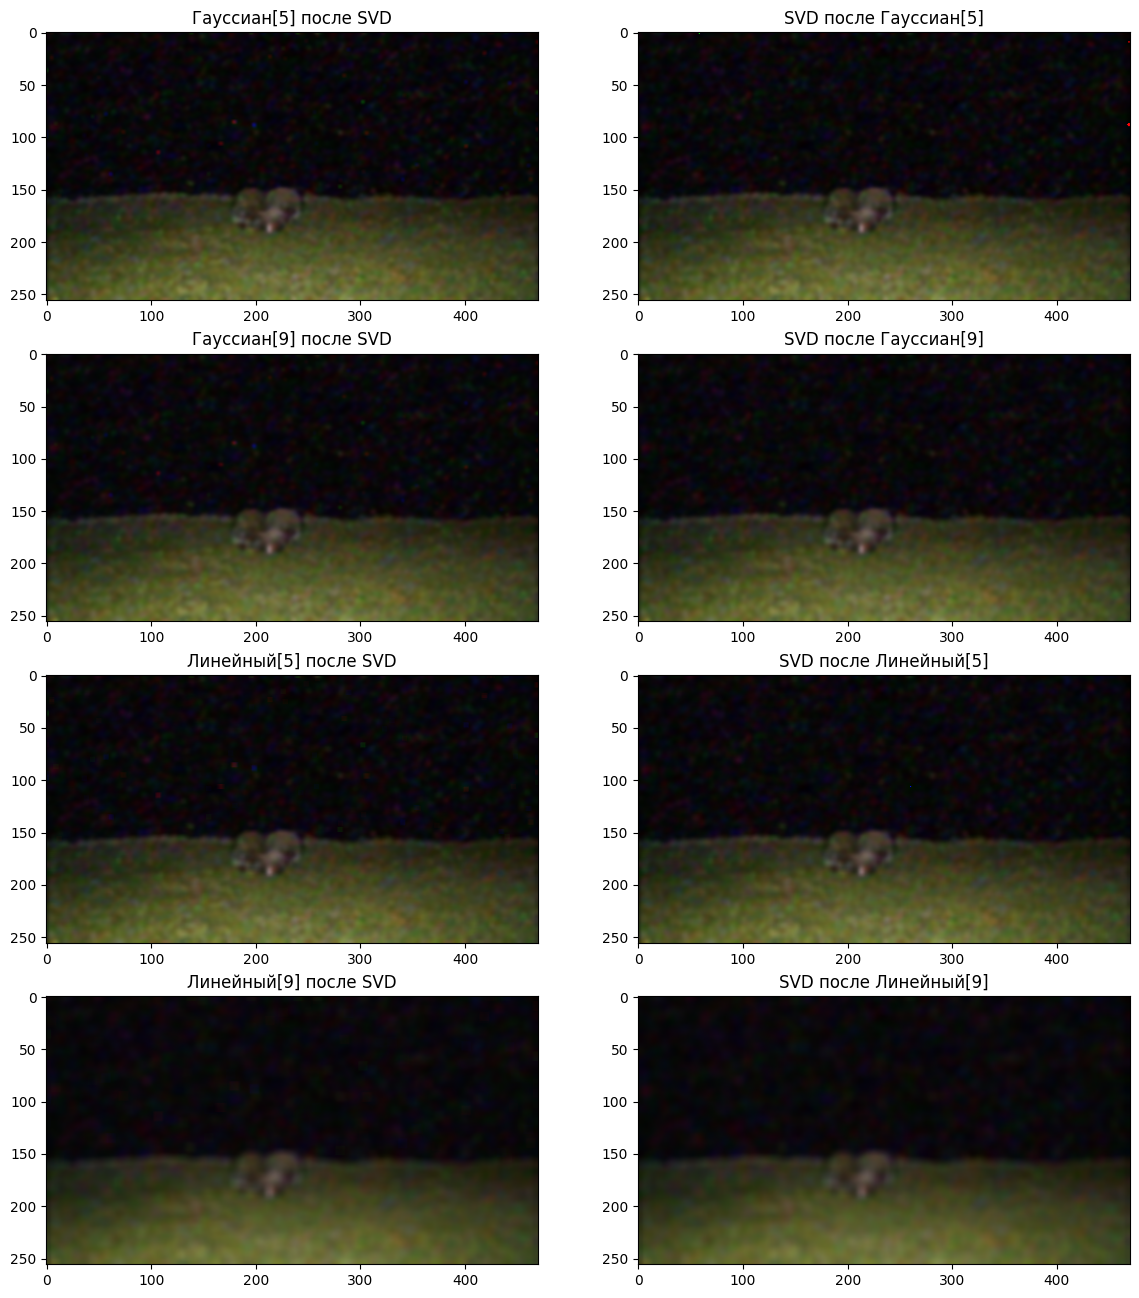

In [8]:
images = [
    blur_gauss(decompose(restored_image), filter_ksize_first),
    decompose(blur_gauss(restored_image, filter_ksize_first)),
    blur_gauss(decompose(restored_image), filter_ksize_second),
    decompose(blur_gauss(restored_image, filter_ksize_second)),
    blur_linear(decompose(restored_image), filter_ksize_first),
    decompose(blur_linear(restored_image, filter_ksize_first)),
    blur_linear(decompose(restored_image), filter_ksize_second),
    decompose(blur_linear(restored_image, filter_ksize_second))
]

labels = [
    'Гауссиан[{}] после SVD'.format(filter_ksize_first),
    'SVD после Гауссиан[{}]'.format(filter_ksize_first),
    'Гауссиан[{}] после SVD'.format(filter_ksize_second),
    'SVD после Гауссиан[{}]'.format(filter_ksize_second),
    'Линейный[{}] после SVD'.format(filter_ksize_first),
    'SVD после Линейный[{}]'.format(filter_ksize_first),
    'Линейный[{}] после SVD'.format(filter_ksize_second),
    'SVD после Линейный[{}]'.format(filter_ksize_second)
]

f, axes = plt.subplots(4, 2, figsize=(14, 16))

for i in range(4):
    for j in range(2):
        axes[i, j].imshow(images[i * 2 + j])
        axes[i, j].set_title(labels[i * 2 + j])

## Низкочастотные фильтры

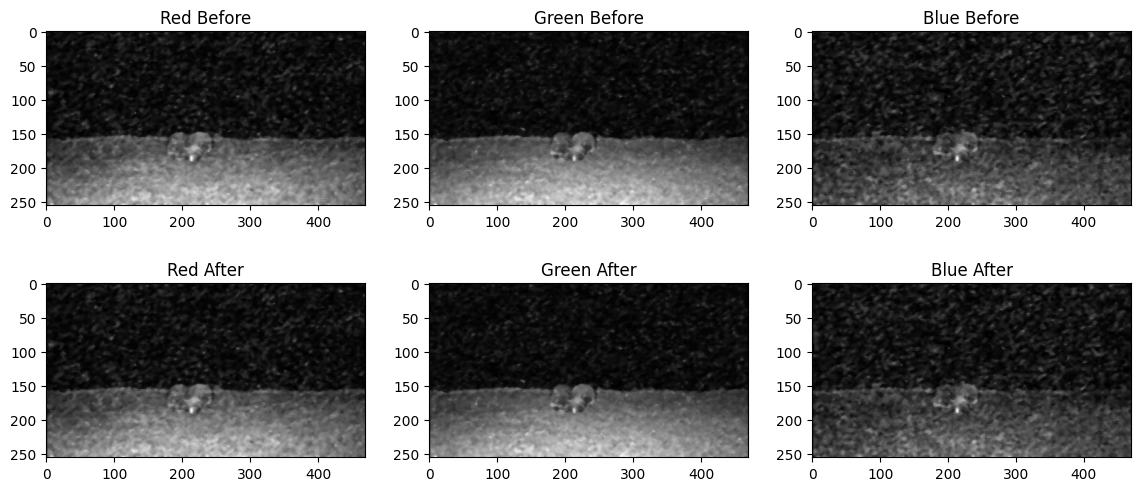

In [9]:
def normalize(image):
    mn = np.min(image)
    mx = np.max(image)
    return (image - mn) / (mx - mn) * 255

def freq_filter(image, plot_layers=False):
    result_image = np.zeros_like(image)

    if plot_layers:
        f, axes = plt.subplots(2, 3, figsize=(14,6))
        label = ['Red', 'Green', 'Blue']

    for channel in range(image.shape[-1]):
        layer = image[..., channel]
        h, w = layer.shape
        
        if plot_layers:
            axes[0, channel].imshow(layer, cmap='gray')
            axes[0, channel].set_title(label[channel] + ' Before')
        layer = layer.astype(np.float32)

        base = np.zeros_like(layer)
        value = 1
        center = (w // 2, h // 2)
        radius = int(0.5 + min(w, h) // 2 * spectre_coeff)
        
        mask = np.zeros((h, w, 2), dtype=layer.dtype)
        
        for t in range(mask.shape[-1]):
            mask[..., t] = cv.circle(base.copy(), center, radius, value, -1)

        dft = cv.dft(layer, flags=cv.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)

        dft_shift = dft_shift * mask
        dft = np.fft.ifftshift(dft_shift)
        
        layer = cv.idft(dft)
        layer = cv.magnitude(layer[..., 0], layer[..., 1])

        if plot_layers:
            axes[1, channel].imshow(layer, cmap='gray')
            axes[1, channel].set_title(label[channel] + ' After')

        result_image[..., channel] = normalize(layer).astype(np.uint8)
    return result_image

high_freq = freq_filter(restored_image, True)

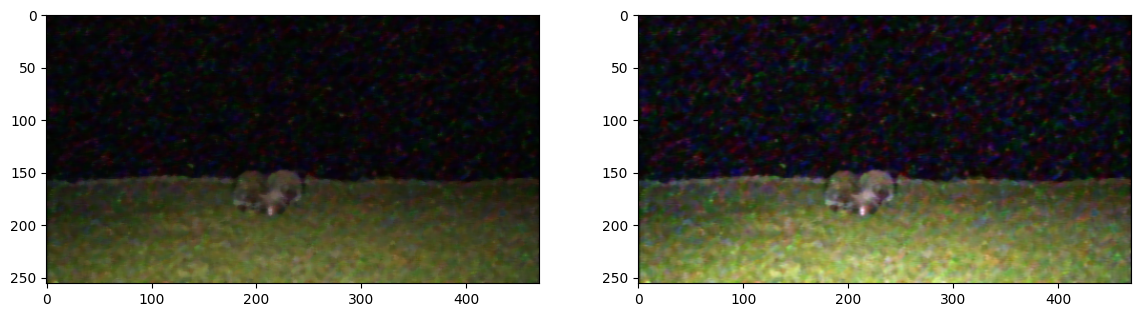

In [10]:
f, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].imshow(restored_image)
ax[1].imshow(high_freq)

# Итоговый конвейер

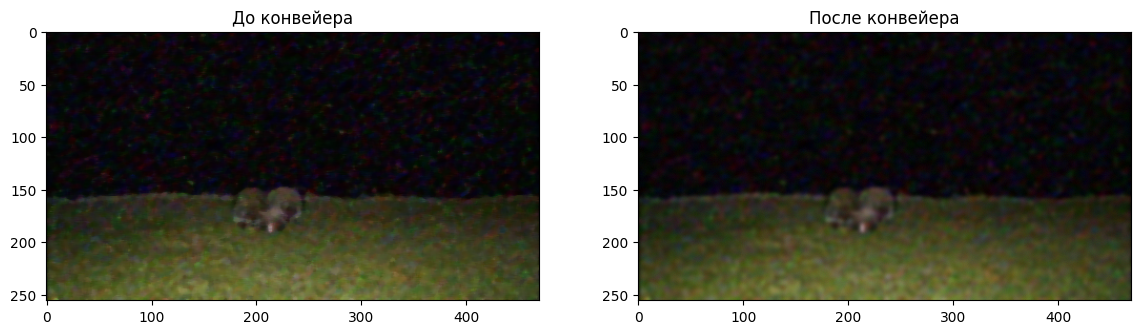

In [11]:
def pipeline(image):
    # image = freq_filter(image)
    image = blur_gauss(image, filter_ksize_second)
    image = decompose(image)
    image = sharpen(image)
    return image


result_image = pipeline(restored_image)

cv.imwrite('images/lab3_blurred.jpg', cv.cvtColor(restored_image, cv.COLOR_RGB2BGR))
cv.imwrite('images/lab3_final.jpg', cv.cvtColor(result_image, cv.COLOR_RGB2BGR))

f, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].set_title('До конвейера'.format(median_ksize))
axes[0].imshow(restored_image)

axes[1].set_title('После конвейера'.format(median_ksize))
axes[1].imshow(result_image)


# Вывод

В результате выполнения работы были рассмотрены различные фильтры, применяемые к изображениям:
- Линейные фильтры для сглаживания и увеличения резкости
- Сглаживание Гауссианом
- Частотные фильтры с использованием преобразования Фурье
- Сжатие изображений с использованием сингулярного разложения

Кроме того, с использованием этих методов, улучшено изображение

![source image](./images/lab3_bad.jpg)